# Senior Thesis - "PLease Don't Sing"

## Build the ML model and assess its accuracy

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.model_selection import KFold
from statistics import median
import numpy as np

import random

### we will load in the data with all of the frequencies and the ratings data

In [4]:
all_audio_freqs = pd.read_csv("C:\\Users\\baile\\OneDrive\\Desktop\\Classes\\Fall2020Classes\\Thesis\\Please_Dont_Sing\\complete_audio_freqs.csv")
ratings = pd.read_csv("C:\\Users\\baile\\OneDrive\\Desktop\\Classes\\Fall2020Classes\\Thesis\\Please_Dont_Sing\\collect_and_clean\\normalized_ratings.csv")
#add the id 
all_audio_freqs['id'] = [("recording" +  str(row) + ".mp3") for row in all_audio_freqs.index]

In [5]:
all_frequencies = all_audio_freqs.merge(ratings, left_on = 'id', right_on = 'rating_id')

In [6]:
all_frequencies.head()

,frequency0,frequency1,frequency2,frequency3,frequency4,frequency5,frequency6,frequency7,frequency8,frequency9,...,frequency996,frequency997,frequency998,frequency999,id,rating_id,rating,z_score,category,binary_category
0,89.24,91.44,263.66,259.14,258.98,259.88,259.23,259.88,258.92,260.93,...,257.51,118.64,89.47,571.12,recording0.mp3,recording0.mp3,9.50,1.562767,good,good
1,94.61,86.30,92.61,87.24,86.69,86.30,86.30,86.30,86.30,88.07,...,92.87,206.11,602.63,351.84,recording1.mp3,recording1.mp3,9.25,1.182873,good,good
2,167.31,114.83,723.74,752.24,749.21,689.08,654.37,826.12,121.32,149.70,...,291.10,298.85,145.92,129.52,recording2.mp3,recording2.mp3,4.00,-1.129216,bad,bad
3,86.30,144.79,86.30,95.89,107.60,112.89,145.41,114.43,128.85,169.06,...,189.87,199.27,98.12,99.59,recording3.mp3,recording3.mp3,9.00,1.450749,good,good
4,206.78,200.73,205.26,203.67,206.61,187.21,187.21,178.24,178.24,178.24,...,254.05,254.05,254.05,212.37,recording4.mp3,recording4.mp3,6.75,0.795809,good,good


### There are about 25 notes in Happy birthday.... let's group those frequencies into groups of 40 (1000 / 25) and see if that correlates more

In [7]:
grouped_frequencies = all_frequencies.drop(['rating', 'z_score', 'category', 'binary_category'], axis = 1)

In [8]:
num_per_section = int(len(grouped_frequencies.columns) / 25)

for chunk in range(25):
    grouped_frequencies['average{}'.format(chunk)] = grouped_frequencies.iloc[:, (chunk * num_per_section): (chunk * num_per_section) + num_per_section].mean(axis = 1)

In [9]:
grouped_frequencies = grouped_frequencies.iloc[ : , -26:]

In [10]:
grouped_frequencies = grouped_frequencies.merge(ratings, left_on = 'rating_id', right_on = 'rating_id')
grouped_frequencies.head()

,rating_id,average0,average1,average2,average3,average4,average5,average6,average7,average8,...,average19,average20,average21,average22,average23,average24,rating,z_score,category,binary_category
0,recording0.mp3,271.24125,366.85975,302.61875,270.1125,249.64125,180.65725,325.74600,358.43775,286.73700,...,717.14225,788.18600,790.29500,672.21525,695.75375,523.63825,9.50,1.562767,good,good
1,recording1.mp3,203.82050,350.06350,307.32675,238.3945,121.51825,291.21550,349.86525,349.05900,342.04475,...,262.90275,381.93575,332.05125,339.95325,350.54550,298.07075,9.25,1.182873,good,good
2,recording2.mp3,226.88225,183.68400,212.75325,279.6780,367.78800,248.77800,236.96075,374.17275,298.21375,...,263.98100,514.64475,633.44250,337.55175,299.54425,342.83075,4.00,-1.129216,bad,bad
3,recording3.mp3,332.76900,309.44525,365.43850,367.7960,271.41925,280.36400,219.27925,410.03100,390.17800,...,489.60000,441.10200,423.10100,407.90200,412.22900,259.11875,9.00,1.450749,good,good
4,recording4.mp3,194.36175,207.98750,202.31650,257.4170,254.08500,244.48000,199.39400,210.66775,276.74175,...,272.23475,265.48325,290.56600,273.24550,257.83900,254.10675,6.75,0.795809,good,good


### Make a dataframe of the differences from each note to the first note

In [11]:
differences = pd.DataFrame()

num = 0
for column in grouped_frequencies.columns.values:
    if pd.api.types.is_numeric_dtype(grouped_frequencies[column]) and column != "rating" and column != "z_score":
        new_val = grouped_frequencies[column] - grouped_frequencies['average0']
        differences.insert(loc = len(differences.columns), column = "difference{}".format(num), value = new_val)
        num += 1
    else:
        differences.insert(loc = len(differences.columns), column = column, value = grouped_frequencies[column])

In [12]:
#remove difference0 (which is all 0s) and add the starting pitch in to be a feature
differences = differences.drop('difference0', axis = 1)
differences['starting_pitch'] = grouped_frequencies['average0']
differences.head()

,rating_id,difference1,difference2,difference3,difference4,difference5,difference6,difference7,difference8,difference9,...,difference20,difference21,difference22,difference23,difference24,rating,z_score,category,binary_category,starting_pitch
0,recording0.mp3,95.61850,31.37750,-1.12875,-21.60000,-90.58400,54.50475,87.1965,15.49575,51.20450,...,516.94475,519.05375,400.97400,424.51250,252.39700,9.50,1.562767,good,good,271.24125
1,recording1.mp3,146.24300,103.50625,34.57400,-82.30225,87.39500,146.04475,145.2385,138.22425,120.32600,...,178.11525,128.23075,136.13275,146.72500,94.25025,9.25,1.182873,good,good,203.82050
2,recording2.mp3,-43.19825,-14.12900,52.79575,140.90575,21.89575,10.07850,147.2905,71.33150,106.64775,...,287.76250,406.56025,110.66950,72.66200,115.94850,4.00,-1.129216,bad,bad,226.88225
3,recording3.mp3,-23.32375,32.66950,35.02700,-61.34975,-52.40500,-113.48975,77.2620,57.40900,-14.75325,...,108.33300,90.33200,75.13300,79.46000,-73.65025,9.00,1.450749,good,good,332.76900
4,recording4.mp3,13.62575,7.95475,63.05525,59.72325,50.11825,5.03225,16.3060,82.38000,86.26675,...,71.12150,96.20425,78.88375,63.47725,59.74500,6.75,0.795809,good,good,194.36175


In [13]:
differences[differences['rating_id'] == "recording9.mp3"]

,rating_id,difference1,difference2,difference3,difference4,difference5,difference6,difference7,difference8,difference9,...,difference20,difference21,difference22,difference23,difference24,rating,z_score,category,binary_category,starting_pitch
9,recording9.mp3,180.565,0.0285,-64.83225,160.68275,222.302,158.58175,125.081,45.7985,149.40575,...,212.3005,88.8625,136.28825,98.456,-7.704,4.0,-0.770723,bad,bad,233.0075


### As we can see below (and we could guess....) the columns of this data will be highly correlated. Because of this multicollinearity and because we have so few data points, Ridge Regression is the best model for our data

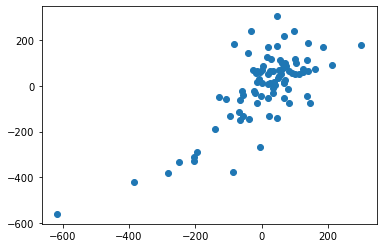

In [14]:
plt.scatter(differences['difference8'], differences['difference10'])

In [22]:
## Using K Fold Cross Validation

In [25]:
def find_class(z_score):
    ret_val = 0
    if z_score < -0.75:
        ret_val = -1
    elif z_score > 0.75:
        ret_val = 1
        
    #if it is between these numbers, we will say it is "okay", or 0
    
    return ret_val
        

In [26]:

kf_residuals  = []
kf_correct = []
kf_error = []

#extract the features and the output
features = differences.drop(['z_score', 'category', 'binary_category', 'rating', 'rating_id'], axis = 1)
output = differences[['z_score']]

predictions = []
#repeated k-fold cross-validation
for i in range(100):
    #split the data
    kf = KFold(n_splits = 10, shuffle = True)

    #for each set of data in the k folds
    for train_index, test_index in kf.split(differences):
        ridge_reg = Ridge()
        #get train and test data
        X_train = features.iloc[train_index, :]
        Y_train = output.iloc[train_index, :]
        X_test = features.iloc[test_index, :]
        Y_test = output.iloc[test_index, :]
        Y_test.reset_index(inplace = True)

        #fit the model
        ridge_reg.fit(X_train, Y_train)

        num_correct = 0
        error = 0
        residuals = []
        predictions.append(ridge_reg.predict(X_test))
        
        #assess the accuracy
        for val in range(len(Y_test)):
            pred_class = find_class(ridge_reg.predict(X_test)[val][0])
            actual_class = find_class(Y_test['z_score'][val])

            if pred_class == actual_class:
                num_correct += 1
            elif abs(pred_class - actual_class) > 1:
                error +=1 
            residuals.append(Y_test['z_score'][val] - ridge_reg.predict(X_test)[val][0])

        kf_correct.append(num_correct / len(Y_test))
        kf_residuals.append(residuals)
        kf_error.append(error / len(Y_test))
        
  

In [27]:
print("Percent correct = ", sum(kf_correct) / len(kf_correct))
print("Percent error = ", sum(kf_error) / len(kf_error))

Percent correct =  0.5876666666666667
Percent error =  0.05098611111111133


In [28]:
ridge_reg.fit(features, output)
ridge_reg.coef_

array([[-1.58164854e-03, -3.37194596e-03,  3.29796055e-04,
        -2.52255190e-03,  6.02937289e-04,  2.77115493e-03,
         6.17397618e-04, -9.20525160e-04,  1.98441018e-03,
        -3.20519941e-03, -1.14513629e-03,  2.26937862e-03,
         9.89206873e-04, -1.03864319e-03, -4.41930178e-04,
         3.72353952e-04,  1.23777565e-03,  1.51823250e-03,
         1.18885602e-03, -8.55981444e-04, -9.49875516e-05,
         2.01299661e-03,  1.78241872e-03, -8.41396633e-04,
        -1.10935798e-04]])

In [29]:
all_residuals = []
for res in kf_residuals:
    for val in res:
        all_residuals.append(val)

In [32]:
abs_residuals = []
for residual in all_residuals:
    abs_residuals.append(abs(residual))
    
print("Overall average of absolute values of residuals is", sum(abs_residuals) / len(abs_residuals))
print("Overall median of absolute values of residuals is", median(abs_residuals))

Overall average of absolute values of residuals is 0.6887964485505798
Overall median of absolute values of residuals is 0.5118688161754468


Text(0.5, 1.0, 'Residuals of K-Fold Cross Validation on Differences')

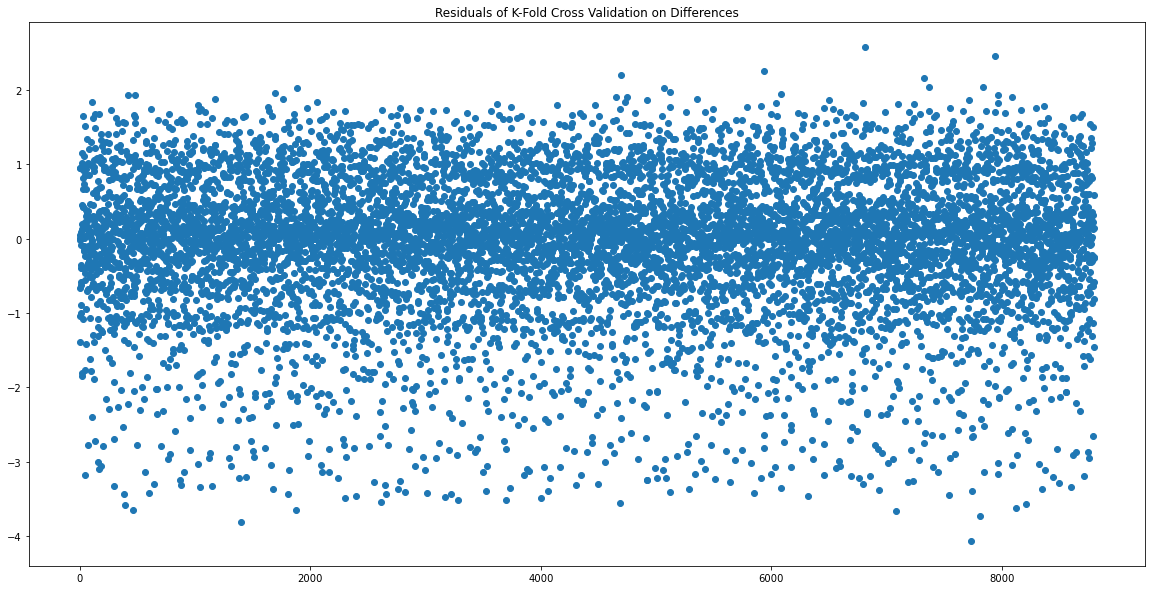

In [33]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(all_residuals)), all_residuals)
plt.title("Residuals of K-Fold Cross Validation on Differences")

Text(0.5, 1.0, 'Frequency of Residuals')

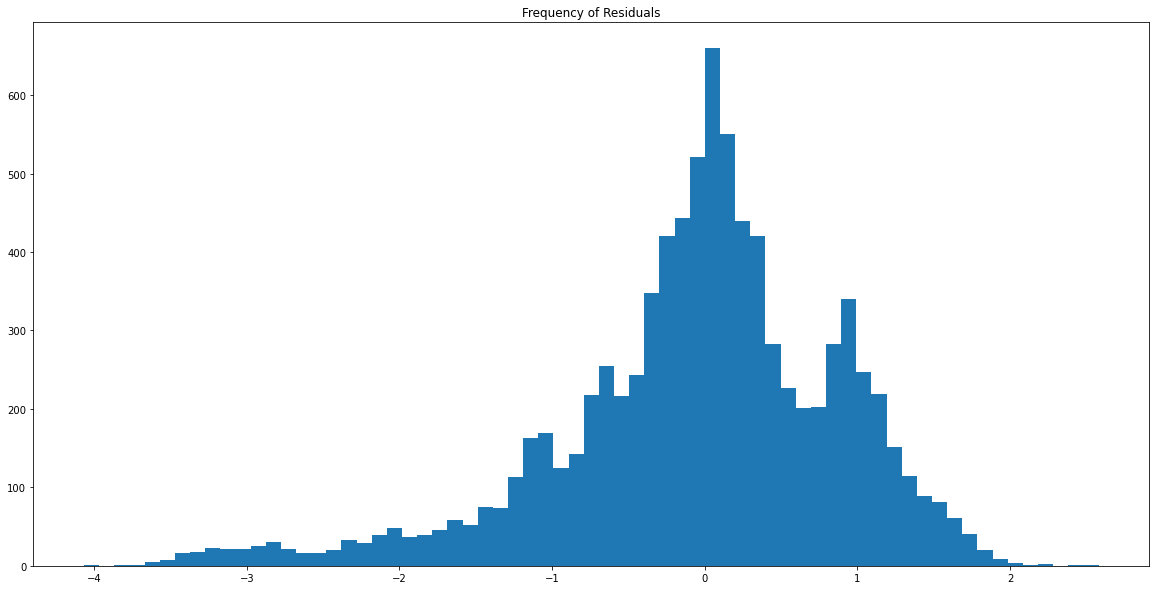

In [34]:
plt.figure(figsize = (20,10))
plt.hist(all_residuals, bins = 'auto')
plt.title("Frequency of Residuals")

In [35]:
#The residuals above look more or less normal, although they are skewed slightly left

There are a couple of recordings that have multiple voices and one that has a lot of background noise and isnt the whole song... i wonder if our model would improve if we dropped those? 

In [36]:
dropped_differences = differences.drop([0,1,2,3,78])
dropped_differences

,rating_id,difference1,difference2,difference3,difference4,difference5,difference6,difference7,difference8,difference9,...,difference20,difference21,difference22,difference23,difference24,rating,z_score,category,binary_category,starting_pitch
4,recording4.mp3,13.62575,7.95475,63.05525,59.72325,50.11825,5.03225,16.30600,82.38000,86.26675,...,71.12150,96.20425,78.88375,63.47725,59.74500,6.750000,0.795809,good,good,194.36175
5,recording5.mp3,13.05750,89.92750,147.65850,115.79450,32.40975,-25.63825,78.71675,66.74475,137.82175,...,17.51675,-108.28375,13.98175,-10.52575,-133.92025,3.500000,-0.698715,bad,bad,366.04375
6,recording6.mp3,27.07025,-8.62550,5.09000,42.41975,28.12200,-60.11225,-24.80550,-18.65100,-35.56700,...,-81.25200,-29.47050,15.14650,-43.80825,-35.11200,3.285714,-1.062922,bad,bad,249.66425
7,recording7.mp3,11.35100,6.35200,63.10175,54.98550,11.15450,-3.44575,41.20175,100.28475,79.49500,...,103.50350,92.71625,95.11375,67.33100,56.31925,6.750000,0.582639,good,good,225.87625
8,recording8.mp3,2.40450,-1.42075,75.32575,29.66850,6.95225,38.31700,9.52350,98.18425,-1.15625,...,147.34475,103.18225,103.18075,103.47300,103.36450,5.750000,-0.268122,okay,bad,290.93100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,recording83.mp3,-1.13850,145.76275,276.53750,70.81450,71.97550,10.64650,-2.56475,45.31975,454.32850,...,196.90200,297.88775,323.42725,374.66650,481.93850,8.125000,1.190325,good,good,299.24625
84,recording84.mp3,10.70350,46.62725,57.79000,109.79850,204.79650,102.11725,109.57400,37.33900,33.68525,...,59.47025,43.57575,56.63350,44.26775,39.87000,8.700000,1.285456,good,good,140.08000
85,recording85.mp3,15.73075,70.78950,9.86600,-23.89750,-30.90600,-81.93700,141.18200,-58.65625,28.60100,...,49.39575,38.86650,-30.24400,-69.12400,-132.44500,3.800000,-0.791304,bad,bad,312.76975
86,recording86.mp3,64.19450,-42.06850,-119.31350,-132.19725,-131.30675,2.24000,54.43375,-69.13175,-90.06250,...,75.77450,-83.67825,-103.25225,-116.59550,-116.07900,7.000000,0.494580,okay,good,392.66300


In [37]:
#do the same thing as above but with the dropped_differences dataframe

In [38]:

kf_residuals  = []
kf_correct = []
kf_error = []

#extract the features and the output
features = dropped_differences.drop(['z_score', 'category', 'binary_category', 'rating', 'rating_id'], axis = 1)
output = dropped_differences[['z_score']]

predictions = []
#repeated k-fold cross-validation
for i in range(100):
    #split the data
    kf = KFold(n_splits = 10, shuffle = True)

    #for each set of data in the k folds
    for train_index, test_index in kf.split(dropped_differences):
        ridge_reg = Ridge()
        #get train and test data
        X_train = features.iloc[train_index, :]
        Y_train = output.iloc[train_index, :]
        X_test = features.iloc[test_index, :]
        Y_test = output.iloc[test_index, :]
        Y_test.reset_index(inplace = True)

        #fit the model
        ridge_reg.fit(X_train, Y_train)

        num_correct = 0
        error = 0
        residuals = []
        predictions.append(ridge_reg.predict(X_test))
        
        #assess the accuracy
        for val in range(len(Y_test)):
            pred_class = find_class(ridge_reg.predict(X_test)[val][0])
            actual_class = find_class(Y_test['z_score'][val])

            if pred_class == actual_class:
                num_correct += 1
            elif abs(pred_class - actual_class) > 1:
                error +=1 
            residuals.append(Y_test['z_score'][val] - ridge_reg.predict(X_test)[val][0])

        kf_correct.append(num_correct / len(Y_test))
        kf_residuals.append(residuals)
        kf_error.append(error / len(Y_test))
        
  

In [39]:
print("Percent correct = ", sum(kf_correct) / len(kf_correct))
print("Percent error = ", sum(kf_error) / len(kf_error))

Percent correct =  0.5811111111111111
Percent error =  0.05426388888888899


In [40]:
#it doesn't look like dropping those observations has improved accuracy at all, so we will keep them in there

### What about K-Fold with random numbers as predictions?? (our model should perform better than this)


In [41]:
rand_kf_residuals  = []
rand_kf_correct = []
rand_error = []

#extract the features and the output
features = grouped_frequencies.drop(['z_score', 'category', 'binary_category', 'rating', 'rating_id'], axis = 1)
output = grouped_frequencies[['z_score']]

#repeated k-fold cross-validation
for i in range(1):
    #split the data
    kf = KFold(n_splits = 10, shuffle = True)

    #for each set of data in the k folds
    for train_index, test_index in kf.split(features):
        ridge_reg = Ridge()
        #get train and test data
        X_train = features.iloc[train_index, :]
        Y_train = output.iloc[train_index, :]
        X_test = features.iloc[test_index, :]
        Y_test = output.iloc[test_index, :]
        Y_test.reset_index(inplace = True)

        #fit the model
        random_numbers = []
        for val in range(len(Y_test)):
            random_numbers.append(random.randrange(-200000, 200000) / 100000)

        random_numbers = np.array(random_numbers).reshape(-1,1)


        num_correct = 0
        error = 0
        residuals = []

        #assess the accuracy
        for val in range(len(Y_test)):
            pred_class = find_class(random_numbers[val])
            actual_class = find_class(Y_test['z_score'][val])

            if pred_class == actual_class:
                num_correct += 1
            elif abs(pred_class - actual_class) > 1:
                error += 1
            residuals.append(Y_test['z_score'][val] - random_numbers[val])

        rand_kf_correct.append(num_correct / len(Y_test))
        rand_kf_residuals.append(residuals)
        rand_error.append(error / len(Y_test))
        
  

In [42]:
print("Percent correct = ", sum(rand_kf_correct) / len(rand_kf_correct))
print("Percent error = ", sum(rand_error) / len(rand_error))

Percent correct =  0.3861111111111111
Percent error =  0.09305555555555556


### We see above that our model predicts much better (about 25% better) than random, so this is a good sign

In [44]:
differences.to_csv("C:\\Users\\baile\\OneDrive\\Desktop\\Classes\\Fall2020Classes\\Thesis\\Please_Dont_Sing\\build_ML\\audio_differences.csv", index = False)